### Food101 Dataset Subset Loading

This cell defines the `get_data` function, which loads the Food101 dataset, creates subsets for 10 selected classes (160 training and 40 testing samples per class), and returns the training subset, testing subset, and a list of selected class names. The function applies MobileNetV2 transformations from `get_transform` and stores data in `data_path/train` and `data_path/test`. Ensure `data_path` is writable.

In [65]:
from torchvision.datasets import Food101
from torchvision import transforms
from torch.utils.data import Subset
import pathlib
from typing import Tuple, List

def get_data(data_path: pathlib.Path, transform: transforms.Compose) -> Tuple[Subset, Subset, List[str]]:
    """
    Load Food101 dataset and create subsets for training and testing.

    Args:
        data_path (Path): Path to store/load the dataset.
        transform (transforms.Compose): Transformations to apply to the dataset.

    Returns:
        Tuple[Subset, Subset, List[str]]: Training subset, testing subset, and list of class names.
    """
    # Define selected classes
    selected_classes = ['apple_pie', 'donuts', 'french_fries', 'hamburger', 'hot_dog', 
                         'ice_cream', 'pizza', 'steak', 'sushi', 'tacos']

    # Load training data
    food101_train_data = Food101(
        root=data_path / "train",
        split='train',
        transform=transform,
        target_transform=transforms.Lambda(
            lambda y : selected_classes.index(food101_train_data.classes[y]) if food101_train_data.classes[y] in selected_classes else 99
        ),
        download=True
    )

    # Create training subset (max 160 samples per class)
    class_count = {x : 0 for x in range(len(selected_classes))}
    indices = []
    
    for i, (_, label) in enumerate(food101_train_data):
        if label < len(selected_classes) and class_count[label] < 160:
            class_count[label] += 1
            indices.append(i)

    train_data = Subset(
        dataset=food101_train_data, 
        indices=indices
    )

    # Load test data
    food101_test_data = Food101(
        root=data_path / "test",
        split='test',
        transform=transform,
        target_transform=transforms.Lambda(
            lambda y: selected_classes.index(food101_test_data.classes[y]) if food101_test_data.classes[y] in selected_classes else 99
        ),
        download=True
    )

    # Create test subset (max 40 samples per class)
    class_count = {x : 0 for x in range(len(selected_classes))}
    indices = []

    for i, (_, label) in enumerate(food101_test_data):
        if label < len(selected_classes) and class_count[label] < 40:
            class_count[label] += 1
            indices.append(i)

    test_data = Subset(
        dataset=food101_test_data,
        indices=indices
    )
        
    return train_data, test_data, selected_classes

### DataLoader Creation for Food101

This cell defines the `get_dataloaders` function, which creates PyTorch DataLoader objects for training and testing subsets of the Food101 dataset. It uses a batch size of 32, disables multiprocessing (`num_workers=0`), enables shuffling for training, and disables it for testing. The function returns DataLoaders for both datasets, optimized with `pin_memory=True` for potential GPU usage.

In [66]:
from torch.utils.data import DataLoader, Subset
from typing import Tuple

def get_dataloaders(train_data: Subset, test_data: Subset) -> Tuple[DataLoader, DataLoader]:
    """
    Create DataLoader objects for training and testing datasets.

    Args:
        train_data (Subset): Training dataset subset.
        test_data (Subset): Testing dataset subset.

    Returns:
        Tuple[DataLoader, DataLoader]: DataLoaders for training and testing datasets.
    """
    # Create dataloader for training dataset
    train_dataloader = DataLoader(
        dataset=train_data,
        batch_size=32,
        num_workers=0,
        shuffle=True,
        pin_memory=True
    )

    # Create dataloader for testing dataset
    test_dataloader = DataLoader(
        dataset=test_data,
        batch_size=32,
        num_workers=0,
        shuffle=False,
        pin_memory=True
    )

    return train_dataloader, test_dataloader

### MobileNetV2 Model Setup
This cell defines the `get_model` function, which loads a pre-trained MobileNetV2 model, freezes its parameters, and replaces the classification head with a dropout (p=0.2) and linear layer for the specified number of output classes. The function returns the modified model for transfer learning. Ensure `out_features` matches the dataset’s classes.

In [3]:
from torchvision.models import MobileNet_V2_Weights, mobilenet_v2
from torch import nn

def get_model(out_features: int) -> nn.Module:
    """
    Create a MobileNetV2 model with a modified classification head for transfer learning.

    Args:
        out_features (int): Number of output classes for the classification head.

    Returns:
        nn.Module: Modified MobileNetV2 model with frozen parameters and a new classification head.
    """
    # Load pre-trained MobileNetV2 model
    model = mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)

    # Freeze all parameters
    for param in model.parameters():
        param.requires_grad = False

    # Replace the classification head
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2, inplace=False),
        nn.Linear(in_features=1280, out_features=out_features, bias=True)
    )

    return model

### MobileNetV2 Image Transformations
This cell defines the `get_transform` function, which retrieves the default image transformation pipeline for the pre-trained MobileNetV2 model from torchvision. The transformations include resizing, tensor conversion, and ImageNet normalization, suitable for MobileNetV2. The function returns a `transforms.Compose` object.

In [4]:
from torchvision.models import MobileNet_V2_Weights
from torchvision import transforms

def get_transform() -> transforms.Compose:
    """
    Retrieve the default image transformations for the pre-trained MobileNetV2 model.

    Returns:
        transforms.Compose: A composed transform pipeline for MobileNetV2.
    """
    return MobileNet_V2_Weights.DEFAULT.transforms()

### Model Training and Evaluation
This cell defines the `train_set` and `test_set` functions for training and evaluating a PyTorch model on a dataset. The `train_set` function runs one epoch of training, updating model parameters using the specified optimizer and loss function. The `test_set` function evaluates the model without gradient computation. Both functions calculate average loss and accuracy (in percentage) on the given device (e.g., CPU or GPU). Ensure the model, DataLoader, loss function, and device are compatible with the target dataset.

In [69]:
from sklearn.metrics import accuracy_score
import torch
from typing import Tuple

def train_set(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module, 
              optimizer: torch.optim.Optimizer, 
              device: torch.device) -> Tuple[float, float]:
    """
    Train the model for one epoch on the training dataset.

    Args:
        model (torch.nn.Module): The neural network model to train.
        dataloader (torch.utils.data.DataLoader): DataLoader for the training dataset.
        loss_fn (torch.nn.Module): Loss function for training.
        optimizer (torch.optim.Optimizer): Optimizer for updating model parameters.
        device (torch.device): Device to run the model on (e.g., 'cuda' or 'cpu').

    Returns:
        Tuple[float, float]: Average training loss and accuracy (in percentage) for the epoch.
    """
    model.train()
    train_loss = 0.0
    accuracy = 0.0

    for X, y in dataloader:
        # Move data to device
        X, y = X.to(device), y.to(device)
        
        # Forward pass
        y_logits = model(X)
        loss = loss_fn(y_logits, y)
        
        # Compute predictions and accuracy
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
        # Move to CPU and convert to NumPy for sklearn
        y_cpu, y_pred_cpu = y.cpu().detach().numpy(), y_pred.cpu().detach().numpy()
        accuracy += accuracy_score(y_cpu, y_pred_cpu)

        train_loss += loss.item()
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Compute average loss and accuracy
    train_loss /= len(dataloader)
    accuracy = (accuracy / len(dataloader)) * 100

    return train_loss, accuracy


def test_set(model: torch.nn.Module, 
             dataloader: torch.utils.data.DataLoader, 
             loss_fn: torch.nn.Module, 
             device: torch.device) -> Tuple[float, float]:
    """
    Evaluate the model on the test dataset.

    Args:
        model (torch.nn.Module): The neural network model to evaluate.
        dataloader (torch.utils.data.DataLoader): DataLoader for the test dataset.
        loss_fn (torch.nn.Module): Loss function for evaluation.
        device (torch.device): Device to run the model on (e.g., 'cuda' or 'cpu').

    Returns:
        Tuple[float, float]: Average test loss and accuracy (in percentage).
    """
    model.eval()
    test_loss = 0.0
    accuracy = 0.0

    with torch.inference_mode():
        for X, y in dataloader:
            # Move data to device
            X, y = X.to(device), y.to(device)
            
            # Forward pass
            y_logits = model(X)
            loss = loss_fn(y_logits, y)
            
            # Compute predictions and accuracy
            y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
            # Move to CPU and convert to NumPy for sklearn
            y_cpu, y_pred_cpu = y.cpu().detach().numpy(), y_pred.cpu().detach().numpy()
            accuracy += accuracy_score(y_cpu, y_pred_cpu)
            
            test_loss += loss.item()

    # Compute average loss and accuracy
    test_loss /= len(dataloader)
    accuracy = (accuracy / len(dataloader)) * 100

    return test_loss, accuracy

### Training and Evaluation Loop
This cell defines the `engine` function, which trains and evaluates the PyTorch model over multiple epochs on a dataset. It uses `train_set` for training and `test_set` for evaluation, tracking epoch numbers, training loss, training accuracy, test loss, and test accuracy in a dictionary. Progress is printed after each epoch, showing loss and accuracy metrics. Ensure the model, DataLoaders, loss function, optimizer, and device are compatible with the target dataset.

In [70]:
import torch
from typing import Dict, List

def engine(model: torch.nn.Module, 
           train_dataloader: torch.utils.data.DataLoader,
           test_dataloader: torch.utils.data.DataLoader, 
           loss_fn: torch.nn.Module, 
           optimizer: torch.optim.Optimizer, 
           device: torch.device, 
           epochs: int) -> Dict[str, List[float]]:
    """
    Train and evaluate a PyTorch model over multiple epochs, tracking performance metrics.

    Args:
        model (torch.nn.Module): The neural network model to train and evaluate.
        train_dataloader (torch.utils.data.DataLoader): DataLoader for the training dataset.
        test_dataloader (torch.utils.data.DataLoader): DataLoader for the test dataset.
        loss_fn (torch.nn.Module): Loss function for training and evaluation.
        optimizer (torch.optim.Optimizer): Optimizer for updating model parameters.
        device (torch.device): Device to run the model on (e.g., 'cuda' or 'cpu').
        epochs (int): Number of training epochs.

    Returns:
        Dict[str, List[float]]: Dictionary containing lists of epoch numbers, training losses,
                                training accuracies, test losses, and test accuracies.
    """
    # Initialize results dictionary
    result = {
        'epoch': [],
        'train_loss': [],
        'train_acc': [],
        'test_loss': [],
        'test_acc': []
    }

    for i in range(epochs):
        # Train for one epoch
        train_loss, train_acc = train_set(
            model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            device=device
        )

        # Evaluate on test set
        test_loss, test_acc = test_set(
            model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn,
            device=device
        )

        # Store metrics
        result['epoch'].append(i + 1)
        result['train_loss'].append(train_loss)
        result['train_acc'].append(train_acc)
        result['test_loss'].append(test_loss)
        result['test_acc'].append(test_acc)

        # Print progress
        print(f"Epoch {i + 1} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%")

    return result

### Model Saving
This cell defines the `save_model` function, which saves a PyTorch model’s state dictionary to a specified path with a `.pth` extension. It creates the directory if needed and prints a confirmation. Use after training with `get_model(out_features=10)` for the Food101 dataset with 10 classes.

In [71]:
import torch
from pathlib import Path

def save_model(model: torch.nn.Module, path: Path, name: str) -> None:
    """
    Save the model's state dictionary to a specified file path.

    Args:
        path (Path): Directory path where the model will be saved.
        model (torch.nn.Module): The PyTorch model to save.
        name (str): Filename for the model

    Returns:
        None: The function saves the model and prints a confirmation message.
    """
    # Ensure the directory exists
    path.mkdir(parents=True, exist_ok=True)
    
    # Define the file path
    file_name = path / name
    
    # Save the model's state dictionary
    torch.save(obj=model.state_dict(), f=file_name)
    
    # Print confirmation
    print(f"The model has been saved successfully to {file_name}")

### Food101 Dataset Setup
This cell sets up the data loading for the Food101 dataset. It defines the data path (`../data`), retrieves the default MobileNetV2 transformations using `get_transform`, and loads the training and testing subsets (160 and 40 samples per class, respectively) along with class names using `get_data`. Ensure the data path is valid and writable for downloading/storing the dataset.

In [72]:
from pathlib import Path

# Define data path
data_path = Path("../data")

# Get default MobileNetV2 transformations
auto_transform = get_transform()

# Load Food101 training and testing datasets
train_data, test_data, classes = get_data(
    data_path=data_path,
    transform=auto_transform
)

### Visualize Random Food101 Training Images
This cell visualizes a 3x3 grid of random images from the Food101 training dataset using Matplotlib. Each image is denormalized (reversing MobileNetV2’s ImageNet normalization) and displayed with its class name as the title.

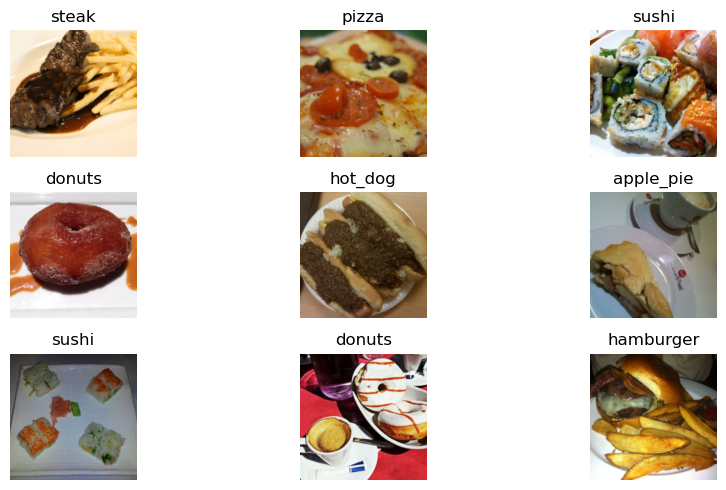

In [73]:
import matplotlib.pyplot as plt
import torch
import numpy as np

# Set up 3x3 subplot grid
nrows, ncols = 3, 3
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 5))

# Inverse normalization for MobileNetV2 (ImageNet mean and std)
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

for i in range(nrows):
    for j in range(ncols):
        # Select a random sample from train_data
        rand_idx = torch.randint(low=0, high=len(train_data), size=(1,)).item()
        image, label = train_data[rand_idx]
        
        # Convert image tensor to NumPy and permute for display (H, W, C)
        image = image.permute(1, 2, 0).numpy()
        
        # Denormalize image for correct visualization
        image = image * std + mean  # Inverse of ImageNet normalization
        image = np.clip(image, 0, 1)  # Ensure pixel values are in [0, 1]
        
        # Display image and set title
        ax[i, j].imshow(image)
        ax[i, j].set_title(classes[label])
        ax[i, j].axis('off')  # Disable axes

# Adjust layout and display
plt.tight_layout()
plt.show()

### DataLoader Setup and Batch Inspection
This cell creates DataLoaders for the Food101 training and testing datasets using `get_dataloaders` with `train_data` and `test_data` from `get_data`. It extracts a sample batch from the training DataLoader and prints the batch shape (expected: `[32, 3, 224, 224]`) and number of labels (expected: 32). This verifies the data pipeline for compatibility with the MobileNetV2 model and Food101 dataset.

In [74]:
from torch.utils.data import DataLoader

# Create DataLoaders for training and testing datasets
train_dataloader, test_dataloader = get_dataloaders(
    train_data=train_data,
    test_data=test_data
)

# Get a sample batch from the training DataLoader
dummy_batch, dummy_batch_labels = next(iter(train_dataloader))

# Inspect the batch shape and label count
print(f"Batch shape: {dummy_batch.shape}")
print(f"Number of labels in batch: {len(dummy_batch_labels)}")

Batch shape: torch.Size([32, 3, 224, 224])
Number of labels in batch: 32


### Device and Model Initialization
This cell sets the computation device (GPU if available, else CPU) and initializes a MobileNetV2 model using `get_model` with output features matching the number of selected classes from the Food101 dataset. The model is moved to the specified device, ready for training or evaluation. Ensure GPU drivers and CUDA are installed for GPU usage, and `classes` is from `get_data`.

In [79]:
import torch

# Set device to GPU if available, otherwise CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize MobileNetV2 model and move to device
model = get_model(out_features=len(classes)).to(device)

### MobileNetV2 Model Architecture Summary
This cell uses `torchinfo` to generate a summary of the MobileNetV2 model’s architecture, including layer details, input/output sizes, number of parameters, and trainability status. The input size `(32, 3, 224, 224)` matches the DataLoader batch format for Food101, and the model is evaluated on the specified device. Ensure `torchinfo` is installed (`pip install torchinfo`) and the model is from `get_model`.

In [80]:
from torchinfo import summary

# Generate MobileNetV2 model summary
summary(
    model=model,
    input_size=(32, 3, 224, 224),
    row_settings=['var_names'],
    col_names=['input_size', 'output_size', 'num_params', 'trainable'],
    col_width=20,
    device=device
)

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
MobileNetV2 (MobileNetV2)                     [32, 3, 224, 224]    [32, 10]             --                   Partial
├─Sequential (features)                       [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)               [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                        [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                   [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─ReLU6 (2)                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─InvertedResidual (1)                   [32, 32, 112, 112]   [32, 16, 112, 112]   --                   False
│    │    └─Sequential (conv)                 [32, 32, 112, 112]   [32, 16, 1

### Training Setup and Execution
This cell sets up the loss function (`CrossEntropyLoss`), optimizer (`Adam`, lr=0.001), and number of epochs (50) for training the MobileNetV2 model on Food101. It runs the training and evaluation loop using `engine`, measures the total time, and returns a dictionary of epoch-wise metrics (train/test loss and accuracy). Ensure the model, DataLoaders, and device are from prior setups (`get_model`, `get_dataloaders`, etc.).

In [82]:
import torch
from timeit import default_timer as timer

# Define loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 50

# Record start time
start = timer()

# Run training and evaluation loop
result = engine(
    model=model,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    device=device,
    epochs=epochs
)

# Record end time and calculate duration
end = timer()
print(f"Time taken to train the model: {end - start:.2f} seconds")

Epoch 1 | Train Loss: 1.9444 | Train Acc: 45.81% | Test Loss: 1.5385 | Test Acc: 69.23%
Epoch 2 | Train Loss: 1.4020 | Train Acc: 67.81% | Test Loss: 1.1688 | Test Acc: 73.32%
Epoch 3 | Train Loss: 1.1152 | Train Acc: 74.00% | Test Loss: 0.9852 | Test Acc: 76.92%
Epoch 4 | Train Loss: 0.9609 | Train Acc: 77.31% | Test Loss: 0.8876 | Test Acc: 77.64%
Epoch 5 | Train Loss: 0.8638 | Train Acc: 78.19% | Test Loss: 0.8258 | Test Acc: 80.05%
Epoch 6 | Train Loss: 0.8076 | Train Acc: 78.62% | Test Loss: 0.7780 | Test Acc: 77.40%
Epoch 7 | Train Loss: 0.7376 | Train Acc: 80.50% | Test Loss: 0.7286 | Test Acc: 80.29%
Epoch 8 | Train Loss: 0.7123 | Train Acc: 80.94% | Test Loss: 0.7167 | Test Acc: 78.61%
Epoch 9 | Train Loss: 0.6701 | Train Acc: 82.25% | Test Loss: 0.7058 | Test Acc: 79.09%
Epoch 10 | Train Loss: 0.6132 | Train Acc: 83.88% | Test Loss: 0.6822 | Test Acc: 78.12%
Epoch 11 | Train Loss: 0.6118 | Train Acc: 84.06% | Test Loss: 0.6623 | Test Acc: 79.57%
Epoch 12 | Train Loss: 0.5589 

### Save Trained Model
This cell defines the model save path (`../model`) and saves the trained MobileNetV2 model’s state dictionary using `save_model`. The model is saved to `../model/mobilenet_v2_on_food101.pth`, with the directory created if needed. Ensure the path is writable.

In [83]:
from pathlib import Path

# Define model file path
model_path = Path("../model")

# Save the trained MobileNetV2 model
save_model(model=model, path=model_path, name='mobilenet_v2_on_food101.pth')

The model has been saved successfully to ../model/mobilenet_v2_on_food101.pth


### Training Metrics Visualization
This cell plots training and testing loss and accuracy over epochs for the MobileNetV2 model on the Food101 dataset (10 classes). It expects a `result` dictionary from `engine` with 'epoch', 'train_loss', 'test_loss', 'train_acc', and 'test_acc'. Run after training to visualize performance. Includes validation to ensure correct input.

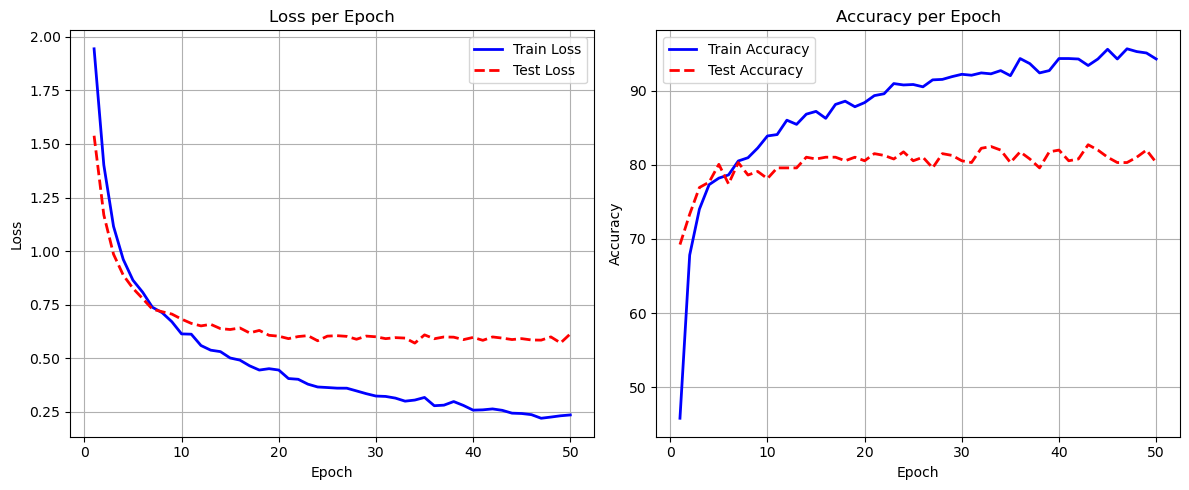

In [89]:
import matplotlib.pyplot as plt

# Create figure and subplots
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(result['epoch'], result['train_loss'], 'b-', label='Train Loss', linewidth=2)
plt.plot(result['epoch'], result['test_loss'], 'r--', label='Test Loss', linewidth=2)
plt.title("Loss per Epoch")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(result['epoch'], result['train_acc'], 'b-', label='Train Accuracy', linewidth=2)
plt.plot(result['epoch'], result['test_acc'], 'r--', label='Test Accuracy', linewidth=2)
plt.title("Accuracy per Epoch")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Adjust layout and display
plt.tight_layout()
plt.show()

# Model Overfitting

The MobileNetV2 model trained on the Food101 dataset shows signs of overfitting, as evidenced by the training loss decreasing and accuracy increasing significantly, while validation loss and accuracy plateau or degrade. This indicates the model is memorizing training data patterns that do not generalize to the validation set.

## Strategies to Reduce Overfitting

To improve generalization, consider the following approaches tailored to MobileNetV2 and Food101:
1. **Data Augmentation**: Apply random crops, flips, rotations, and color jittering to diversify the training images, accounting for variations in food presentation.
2. **Regularization**: Use weight decay (e.g., 1e-4) in the optimizer and add dropout (e.g., 0.2) to the classifier head to reduce model complexity.
3. **Fine-Tuning**: Initially train only the classifier head, then gradually unfreeze later convolutional layers with a smaller learning rate.
4. **Early Stopping**: Monitor validation loss and stop training when it stops improving to prevent overfitting.
5. **Learning Rate Scheduling**: Use a scheduler (e.g., StepLR) to reduce the learning rate over epochs for better convergence.
6. **Cross-Validation**: Implement k-fold cross-validation to ensure robust evaluation across different data splits.
7. **Increase Data**: If possible, supplement Food101 with additional food image data to improve generalization.

## Current Approach
For the time being, a probability threshold is used in the validation function to adjust the decision boundary, which may help balance precision and recall for Food101 classes. This is a temporary measure, and implementing the above strategies is recommended to address overfitting more effectively.

### Validate the Model

Perform inference on an image and return the maximum probability based on the threshold and predicted label.


In [120]:
import torch
from pathlib import Path
import torchvision
from typing import Tuple, Optional

def validate(model: torch.nn.Module, image: torch.Tensor, device: torch.device = torch.device('cpu'), 
             threshold: float = 0.5) -> Tuple[float, int]:
    """
    Perform inference on an image and return the maximum probability and predicted label.

    Args:
        model (torch.nn.Module): The PyTorch model (e.g., MobileNetV2).
        image (torch.Tensor): Input image tensor, shape [3, 224, 224] or [1, 3, 224, 224].
        device (torch.device, optional): Device to run inference on. Defaults to CPU.
        threshold (float, optional): Minimum probability threshold. Defaults to 0.5.

    Returns:
        Tuple[float, int]: Maximum probability and predicted label (or -1 if below threshold).
    """
    image = image.to(device)
    model.to(device)
    model.eval()

    with torch.inference_mode():
        # Ensure batch dimension
        if image.dim() == 3:
            image = image.unsqueeze(dim=0)  # Add batch dimension: [3, 224, 224] -> [1, 3, 224, 224]
        y_logits = model(image)
        y_pred = torch.softmax(y_logits, dim=1)
        max_prob = y_pred.max(dim=1)[0].item()
        y_label = torch.argmax(y_pred, dim=1).item() if max_prob >= threshold else -1

    return max_prob, y_label

### Validate the Model
The MobileNetV2 model on Food101 (10 classes, ~1,600 training, ~400 testing samples, labels 0–9) overfits (low `train_loss`, high `train_acc`, high `test_loss`, low `test_acc`). This cell visualizes 9 random test images in a 3x3 grid, showing true vs. predicted classes and probabilities from `validate` (threshold=0.7). Images are denormalized for display. Green titles indicate correct predictions, red incorrect, and gray low-confidence (below threshold). Uses probability threshold (0.7) in `validate` to reject low-confidence predictions.

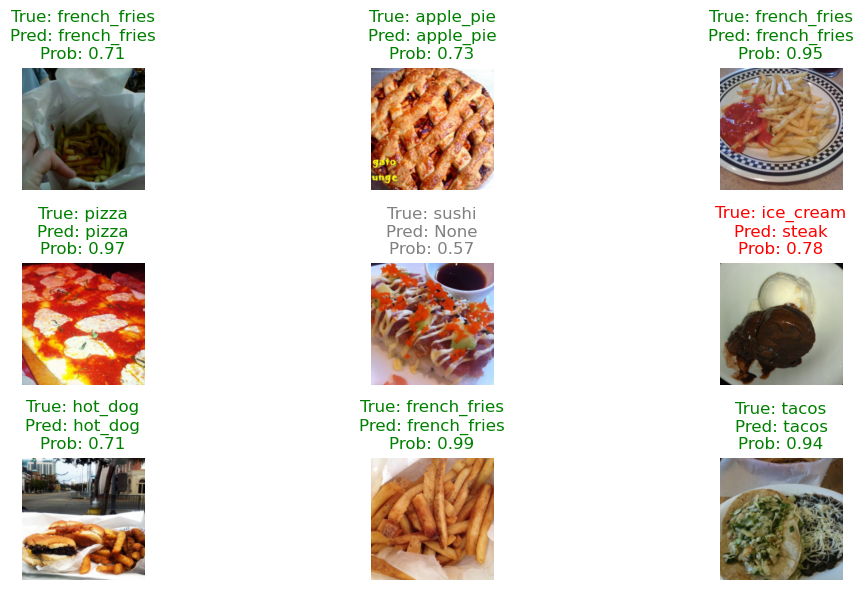

In [131]:
import matplotlib.pyplot as plt
import numpy as np
import torch

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

nrows, ncols = 3, 3
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 6))

for i in range(nrows):
    for j in range(ncols):
        # Choose a random image by using a random index
        rand_idx = torch.randint(0, len(test_data), (1,)).item()
        image, label = test_data[rand_idx]
        true_class = classes[label]

        # Use validate with device and threshold
        pred_prob, pred_label = validate(model, image, device=device, threshold=0.7)
        pred_class = classes[pred_label] if pred_label != -1 else "None"

        # Denormalize image
        image = image.permute(1, 2, 0).numpy() * std + mean
        image = np.clip(image, 0, 1)

        ax[i, j].imshow(image)
        ax[i, j].axis('off')

        # Set title color: green (correct), red (incorrect), gray (below threshold)
        if pred_label == -1:
            ax[i, j].set_title(f'True: {true_class}\nPred: None\nProb: {pred_prob:.2f}', c='gray')
        elif true_class == pred_class:
            ax[i, j].set_title(f'True: {true_class}\nPred: {pred_class}\nProb: {pred_prob:.2f}', c='green')
        else:
            ax[i, j].set_title(f'True: {true_class}\nPred: {pred_class}\nProb: {pred_prob:.2f}', c='red')

plt.tight_layout()
plt.show()

### Import gradio

This cell imports gradio with the common alias gr and if it's not present, install it. 

In [1]:
try:
    import gradio as gr
except:
    !pip install gradio
    import gradio as gr

  Using cached annotated_types-0.7.0-py3-none-any.whl.metadata (15 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.6/59.6 MB 2.5 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 3.0 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.5/561.5 kB 1.5 MB/s eta 0:00:00 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 2.0 MB/s eta 0:00:002.6 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 3.1 MB/s eta 0:00:00m eta 0:00:010:00:01
Using cached annotated_types-0.7.0-py3-none-any.whl (13 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 3.2 MB/s eta 0:00:00 MB/s eta 0:00:01:01
  Attempting uninstall: brotli
    Found existing installation: Brotli 1.0.9
    Uninstalling Brotli-1.0.9:
      Successfully uninstalled Brotli-1.0.9


### Prediction with the model

This cell defines the function `predict(image: PIL.Image)`, which takes a raw image as input, inference the model the provided image and returns the prediction probabilities along with the class. The function loads the model state dictionary from the `../model/mobilenet_v2_on_food101.pth` directory, loads model from the `get_modle(out_features)`, and loads transformation to transform the raw image into respected formats.

In [46]:
import torch
import PIL
from pathlib import Path
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setting device to cpu in order to avoid issues when deploying to gradio.
device = 'cpu'

# These are the classes we are interested in.
selected_classes = ['apple_pie', 'donuts', 'french_fries', 'hamburger', 'hot_dog', 
                    'ice_cream', 'pizza', 'steak', 'sushi', 'tacos']

# Initialize the path to the model.
model_path = Path('../model/mobilenet_v2_on_food101.pth')

def predict(image: PIL.Image) -> Tuple[Dict[str,float], float]:
    """
    This function loads the model, inference the image and predict the probability for each class.

    Args:
        image (PIL.Image): The input image that the model has to predict on.

    Returns:
        Tuple[Dict[str, float], float]: The dictionary of classes along with curresponding probabilities and the prediction time.
    """
    # Starting the time.
    start = timer()

    # Loading the model.
    model_state_dict = torch.load(model_path)
    model = get_model(out_features = len(selected_classes))
    model.load_state_dict(model_state_dict)

    # Get the automatic transforms and transform the image.
    transform = get_transform()
    transformed_image = transform(image).to(device).unsqueeze(dim=0)

    # Put the model in evaluation mode.
    model.to(device).eval()

    with torch.no_grad():
        # Forward pass.
        y_logit = model(transformed_image)

        # Calculate the probability.
        y_prob = torch.softmax(y_logit, dim=1)

    # Calculate each probability with respect to each class.
    pred_labels_and_probs = {selected_classes[i] : y_prob[0][i].item() for i in range(len(selected_classes))}

    # Calculate the prediction time.
    end = timer()
    pred_time = end - start

    return pred_labels_and_probs, pred_time 
    

### Inferece the images.

This cell displays random images along with its prediction probabilites and prediction time from the `predict()` function. 


The prediction result is 

apple_pie	0.006166849285364151
donuts	0.017814725637435913
french_fries	0.000325406261254102
hamburger	0.0006399935227818787
hot_dog	0.05400027707219124
ice_cream	0.008557708002626896
pizza	0.0007428654353134334
steak	0.014619026333093643
sushi	0.8618771433830261
tacos	0.03525598719716072

Time taken to predict = 0.2238691270003983


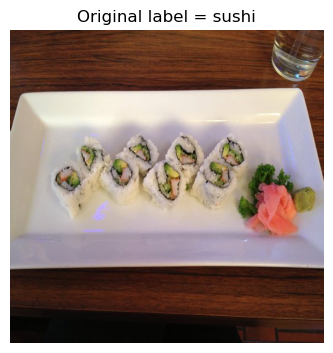


The prediction result is 

apple_pie	0.4676542580127716
donuts	0.09404952079057693
french_fries	0.00017700655735097826
hamburger	0.11989174783229828
hot_dog	0.0003757968661375344
ice_cream	0.07235265523195267
pizza	5.512741336133331e-05
steak	0.24253413081169128
sushi	0.001601080410182476
tacos	0.001308601931668818

Time taken to predict = 0.2955469990001802


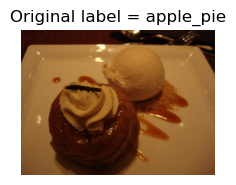


The prediction result is 

apple_pie	0.00068810919765383
donuts	0.0008051336044445634
french_fries	0.6460373997688293
hamburger	0.025040827691555023
hot_dog	0.037944745272397995
ice_cream	4.0080958569888026e-06
pizza	0.0955975204706192
steak	0.16225673258304596
sushi	0.02258175238966942
tacos	0.009043757803738117

Time taken to predict = 0.2979103669995311


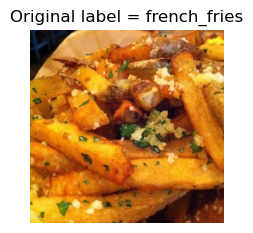

In [47]:
from pathlib import Path
from PIL import Image
import random
import matplotlib.pyplot as plt

# Defining test dataset path.
test_dir = Path('../data/test/food-101/images/')

# Making a list of all filepaths of test images with taking the seleceted classes into consideration.
test_data_paths = []
for i in selected_classes:
    test_data_paths += list(test_dir.glob(f"{i}/*.jpg"))

# Sampling 3 random images from the test data paths.
random_image_paths = random.sample(
    population=test_data_paths,
    k=3
)

# Setting the figure size.
plt.figure(figsize = (10,5))


# Iterating for each image in the sample.
for k, i in enumerate(random_image_paths):

    # Open the image and retrieve the original label.
    image = Image.open(i)
    label = i.parent.stem

    # Predict the image label.
    res, time = predict(image)

    # Plot the image with the original title.
    plt.subplot(1,3,k+1)
    plt.imshow(image)
    plt.axis(False)
    plt.title(f'Original label = {label}')

    # Print the prediction result.
    print(f'\nThe prediction result is \n')
    for a, b in res.items():
        print(f'{a}\t{b}')

    # Print the prediction time.
    print(f'\nTime taken to predict = {time}')

    # Show the plots.
    plt.tight_layout()
    plt.show()

### Deploy the model on Gradio.

This cell uploads the model into the gradio by using `gradio.Interface`. It takes the funcion, inputs, outputs, examples, title and description as parameters.

In [51]:
import gradio as gr

# Create title and description strings.
title = "FoodClassifier Mini"
description = "An MobileNet_V2 feature extractor computer vision model to classify images of food as apple_pie, donuts, french_fries, hamburger, hot_dog, ice_cream, pizza, steak, sushi and tacos."

# Create example image list for gradio.
example_list = [str(x) for x in random_image_paths]

# Creating gradio interface demo.
demo = gr.Interface(
    fn = predict,
    inputs = gr.Image(type='pil'),
    outputs = [
        gr.Label(num_top_classes=3, label='Predictions'),
        gr.Number(label='Prediction time'),
    ],
    examples = example_list,
    title = title,
    description = description
)

# Launch the gradio demo!.
demo.launch(debug=False, share=True)

* Running on local URL:  http://127.0.0.1:7861
* Running on public URL: https://3dd0a36aa7aecde3d7.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
